In [ ]:
# read nc file leopard_sandstone
# https://stackoverflow.com/questions/36360469/read-nc-netcdf-files-using-python
# read 3D with mat73
# !pip install mat73

In [15]:
from pathlib import Path
import os

root_path = '../../data/DeepRockSR/973_2D/images/DeepRockSR-2D/sandstone2D/sandstone2D_train_HR'

hr_images = os.listdir(root_path)

In [11]:
hr_images[0]

'0001x2.png'

(500, 500, 3)


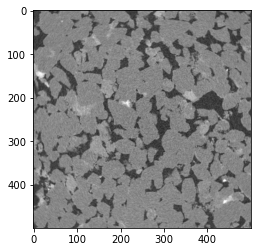

In [16]:
import matplotlib.pyplot as plt
import cv2

image = cv2.imread(os.path.join(root_path, hr_images[0]))
print(image.shape)

plt.imshow(image, cmap='gray')

## Создаем датасет DeepRockSR-2D

In [1]:
import os
import glob
from pathlib import Path
import pandas as pd
import cv2
from PIL import Image

# датасет содержит томографические изображения
# для различных материалов в высоком разрешениии
# серые изображения (500, 500, 3)
# все три канала одинаковые
# - sandstone (песчанник)
# - coal (каменный уголь)
# - carbonate (карбонат: соли, угольная кислота0
# - shuffled материалы в перемешку

In [40]:
!pwd

/home/d_korostelev/Projects/super_resolution/modeling_sr/notebooks


In [49]:
DATA_ROOT = '/home/d_korostelev/Projects/super_resolution/data/DeepRockSR/973_2D/images/DeepRockSR-2D/'
OUTPUT_DATASET_PATH = '/home/d_korostelev/Projects/super_resolution/data/v1_dataset_DeepRockSR.csv'
# типы материалов в датасете
materials = os.listdir(DATA_ROOT)
materials

['sandstone2D', 'carbonate2D', 'coal2D', 'shuffled2D']

In [43]:
split_options = ['train', 'test', 'valid']

result_df = pd.DataFrame(columns=['path', 'material', 'split'])

for mat_name in materials:
    for split_option in split_options:
        images_folder = mat_name + f'_{split_option}_HR'
        images_path = os.path.join(DATA_ROOT, mat_name, images_folder)
        
        class_name = mat_name[:-2]
        images = glob.glob(images_path + '/*.png')
        images_count = len(images)
        mat_df = pd.DataFrame({'path': images,
                                'material': [class_name] * images_count,
                                'split': [split_option] * images_count})
        
        result_df = result_df.append(mat_df, ignore_index=True)

In [44]:
result_df

path   material  split
0      /home/d_korostelev/Projects/super_resolution/d...  sandstone  train
1      /home/d_korostelev/Projects/super_resolution/d...  sandstone  train
2      /home/d_korostelev/Projects/super_resolution/d...  sandstone  train
3      /home/d_korostelev/Projects/super_resolution/d...  sandstone  train
4      /home/d_korostelev/Projects/super_resolution/d...  sandstone  train
...                                                  ...        ...    ...
23995  /home/d_korostelev/Projects/super_resolution/d...   shuffled  valid
23996  /home/d_korostelev/Projects/super_resolution/d...   shuffled  valid
23997  /home/d_korostelev/Projects/super_resolution/d...   shuffled  valid
23998  /home/d_korostelev/Projects/super_resolution/d...   shuffled  valid
23999  /home/d_korostelev/Projects/super_resolution/d...   shuffled  valid

[24000 rows x 3 columns]

In [45]:
result_df.split.value_counts()

train    19200
test      2400
valid     2400
Name: split, dtype: int64

In [46]:
# shuffled - могут быть различные типы материалов
result_df.material.value_counts()

shuffled     12000
sandstone     4000
carbonate     4000
coal          4000
Name: material, dtype: int64

In [51]:
result_df.groupby(["split", "material"]).size()

split  material 
test   carbonate     400
       coal          400
       sandstone     400
       shuffled     1200
train  carbonate    3200
       coal         3200
       sandstone    3200
       shuffled     9600
valid  carbonate     400
       coal          400
       sandstone     400
       shuffled     1200
dtype: int64

sandstone


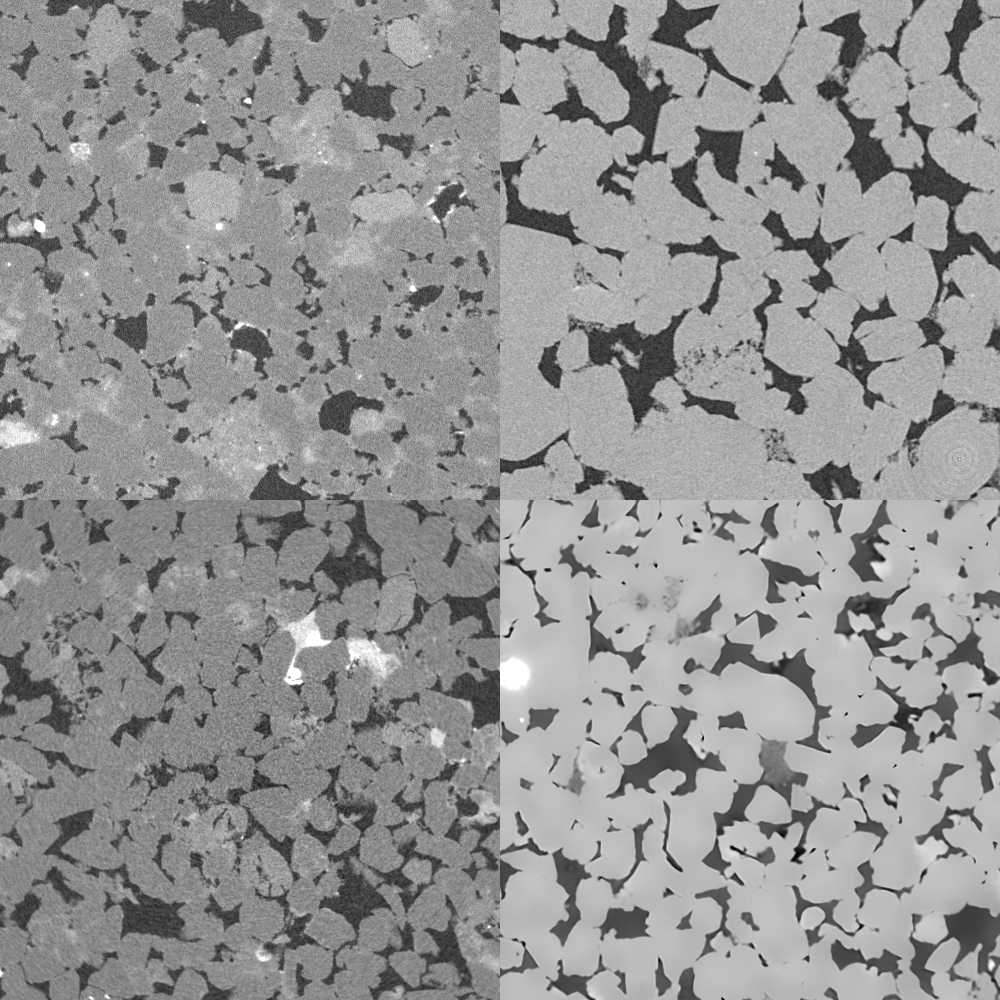

In [71]:
def make_images_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def make_grid(df, rows, cols, title):
    print(title)
    images = [Image.open(path) for path in df.path.values]
    return make_images_grid(images, rows, cols)


make_grid(result_df[result_df.material == 'sandstone'].sample(4), 2, 2, 'sandstone')

coal


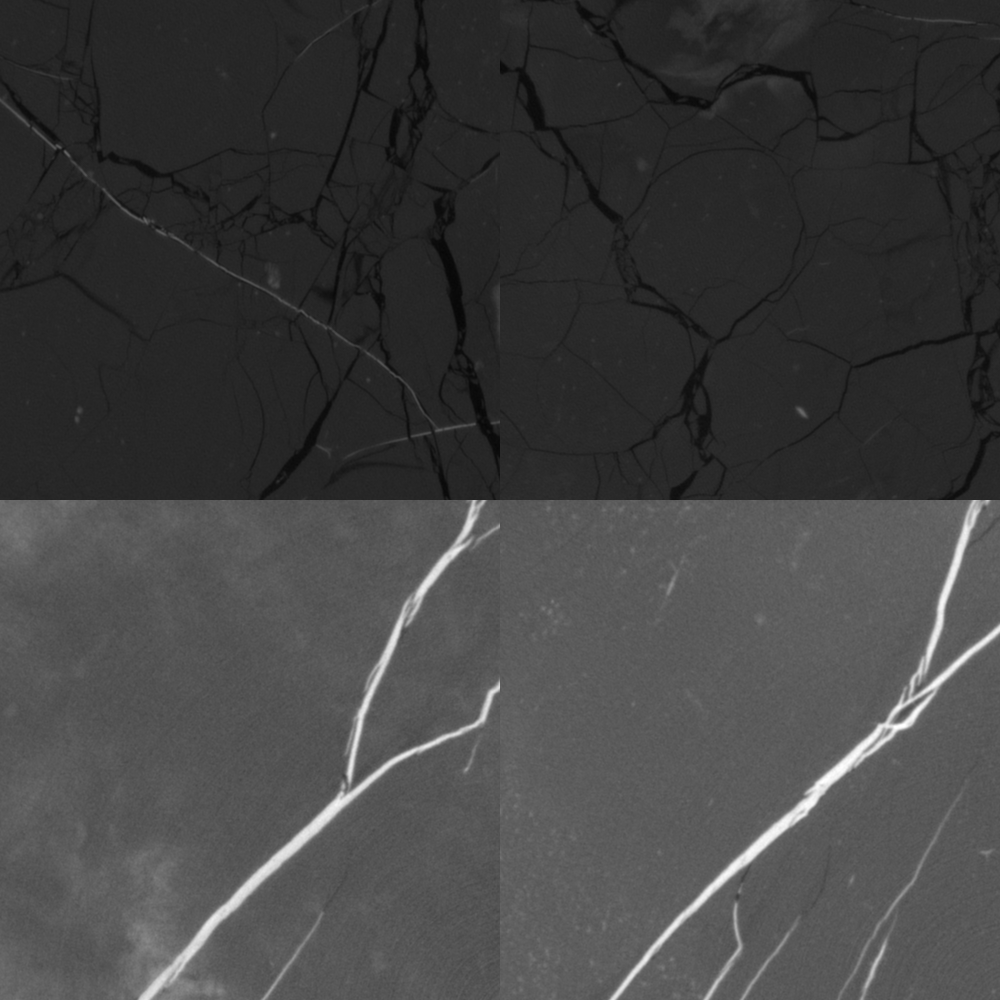

In [37]:
make_grid(result_df[result_df.material == 'coal'].sample(4), 2, 2, 'coal')

carbonate


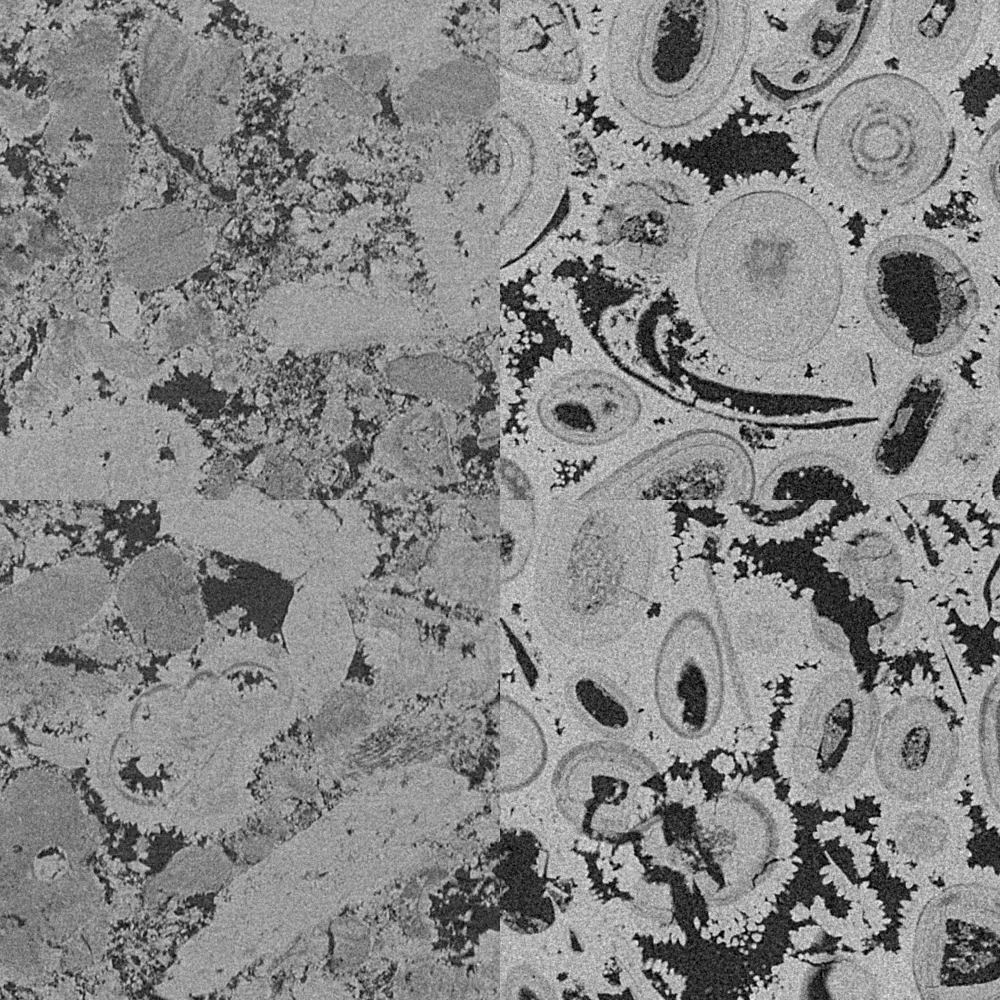

In [38]:
make_grid(result_df[result_df.material == 'carbonate'].sample(4), 2, 2, 'carbonate')

shuffled


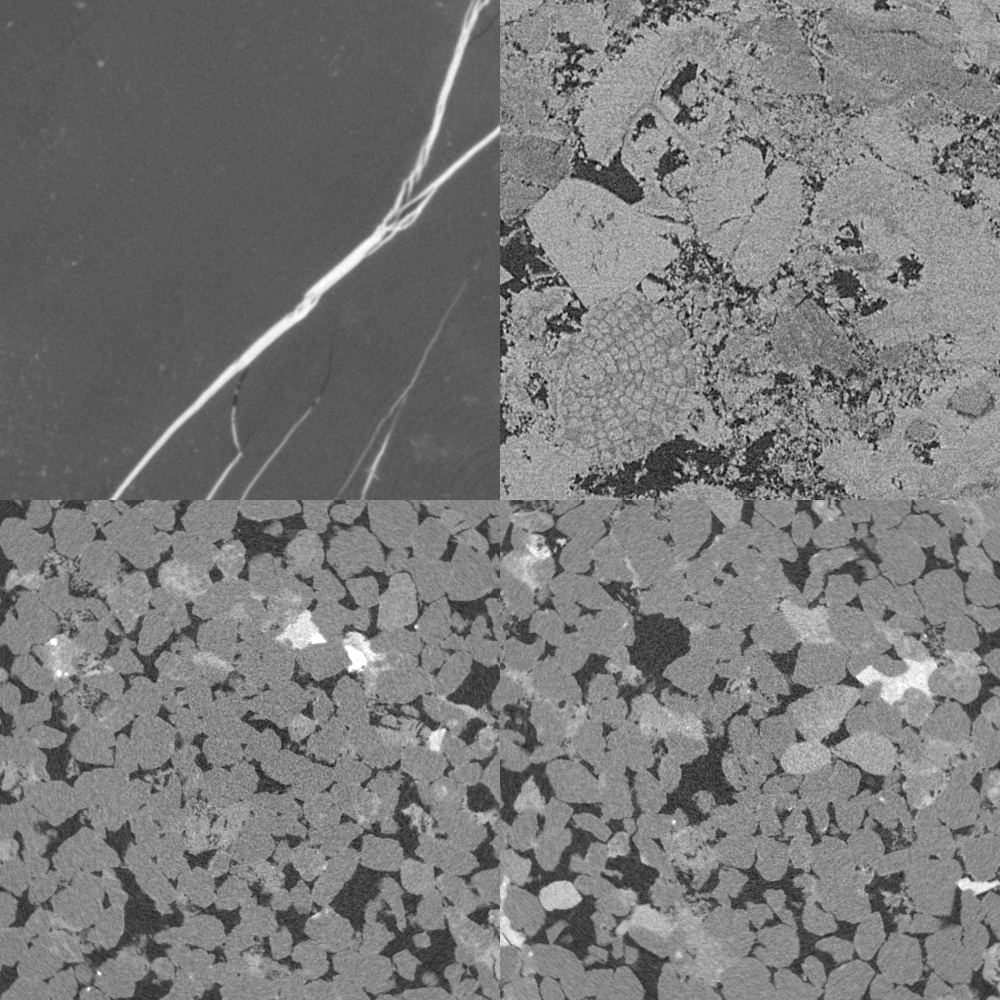

In [39]:
make_grid(result_df[result_df.material == 'shuffled'].sample(4), 2, 2, 'shuffled')

In [63]:
image = cv2.imread(result_df.loc[23000, 'path'])
image.shape

(500, 500, 3)

In [60]:
from tqdm import tqdm 

def check_image(image):
    """Проверяем изображения на валидность."""
    assert image.shape[2] == 3
    assert (image[..., 0] == image[..., 1]).sum() == 250000
    assert (image[..., 1] == image[..., 2]).sum() == 250000

for i, row in tqdm(result_df.iterrows()):
     image = cv2.imread(row['path'])
     check_image(image)

24000it [02:35, 154.64it/s]


In [50]:
result_df.to_csv(OUTPUT_DATASET_PATH, index=False)

## Пример уменьшения разрешения

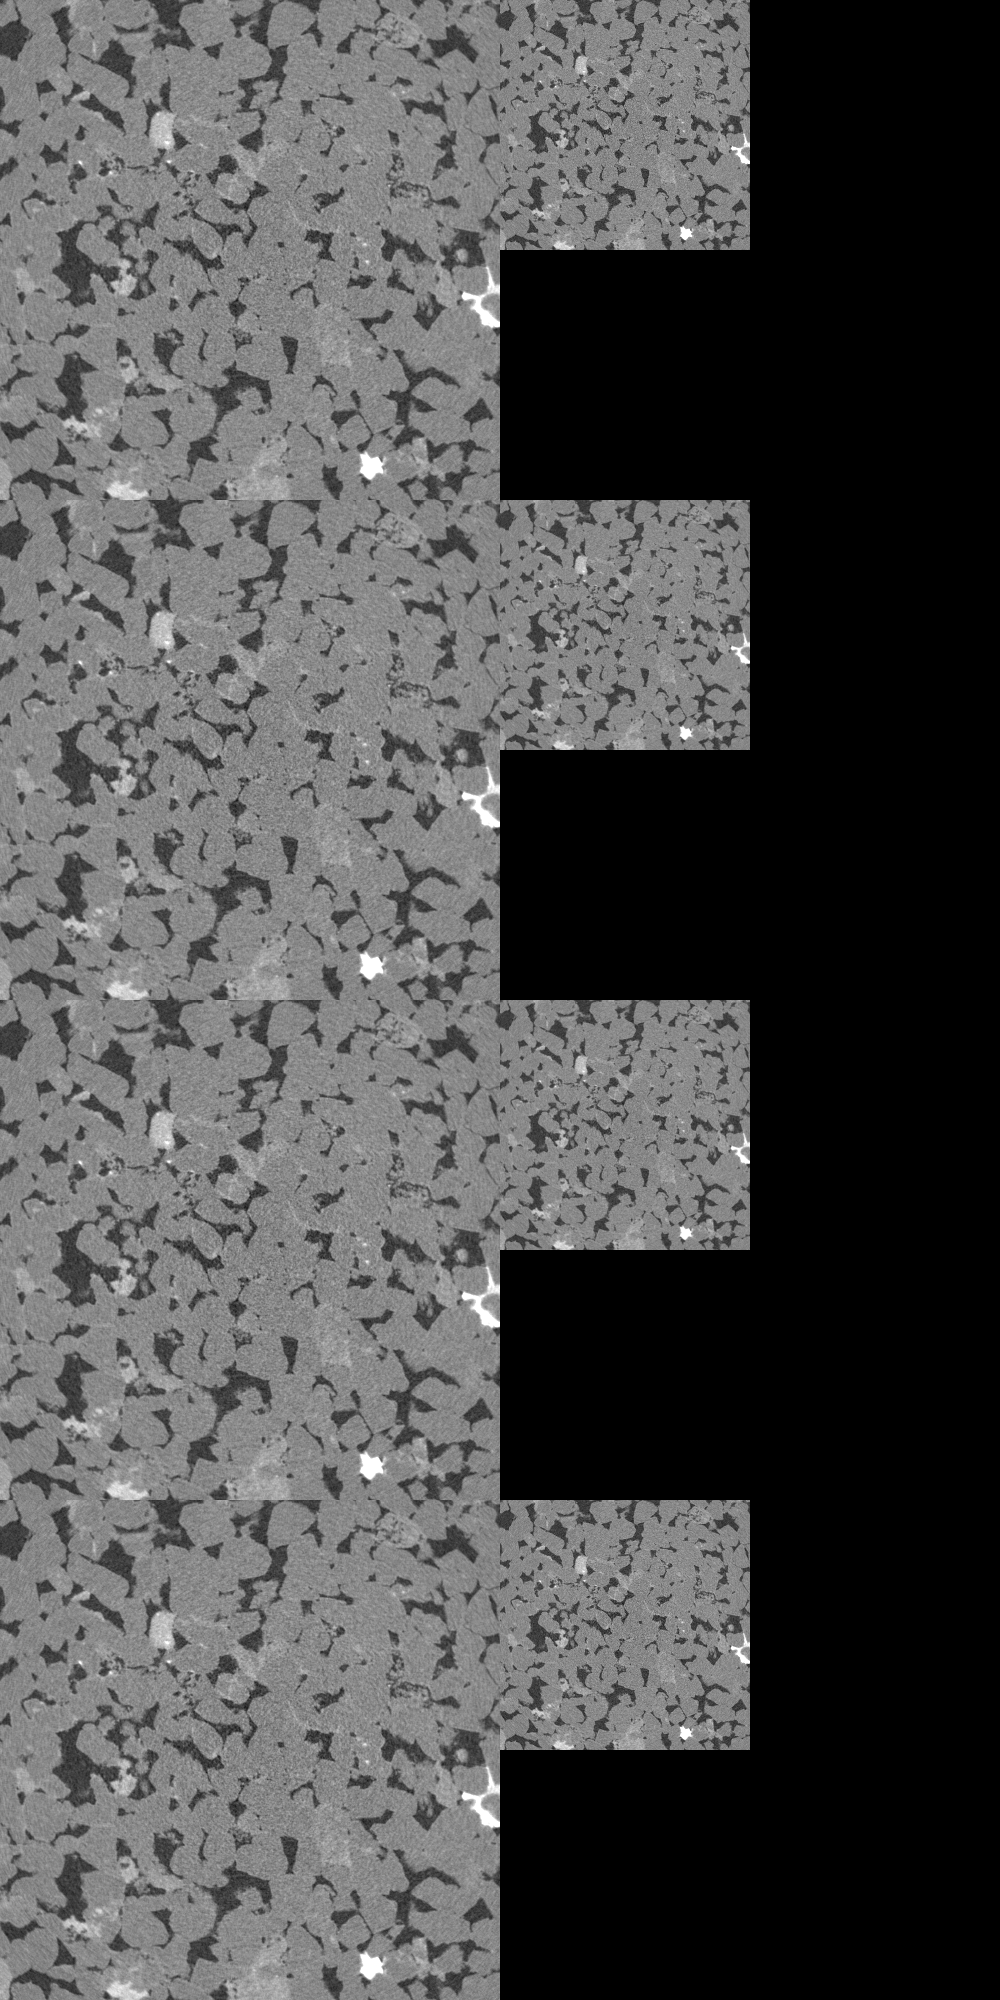

In [98]:
def make_resized_grid(images):
    w, h = images[0].size
    
    orig_image = images[0]
    images = images[1:]
    
    cols = 2
    rows =  len(images)
    
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i in range(rows * cols):
        if i % 2 == 0:
            image = orig_image
        else:
            image = images[i // 2]
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

image = cv2.imread(result_df.loc[200, 'path'])
images = [Image.fromarray(image)]

resize_factor = 2
dest_size = (image.shape[0]//resize_factor, image.shape[1]//resize_factor)
# INTER_LINEAR - default
for method in [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_AREA, cv2.INTER_CUBIC]:
    images.append(Image.fromarray(cv2.resize(image, dest_size, interpolation=method)))
    
make_resized_grid(images)

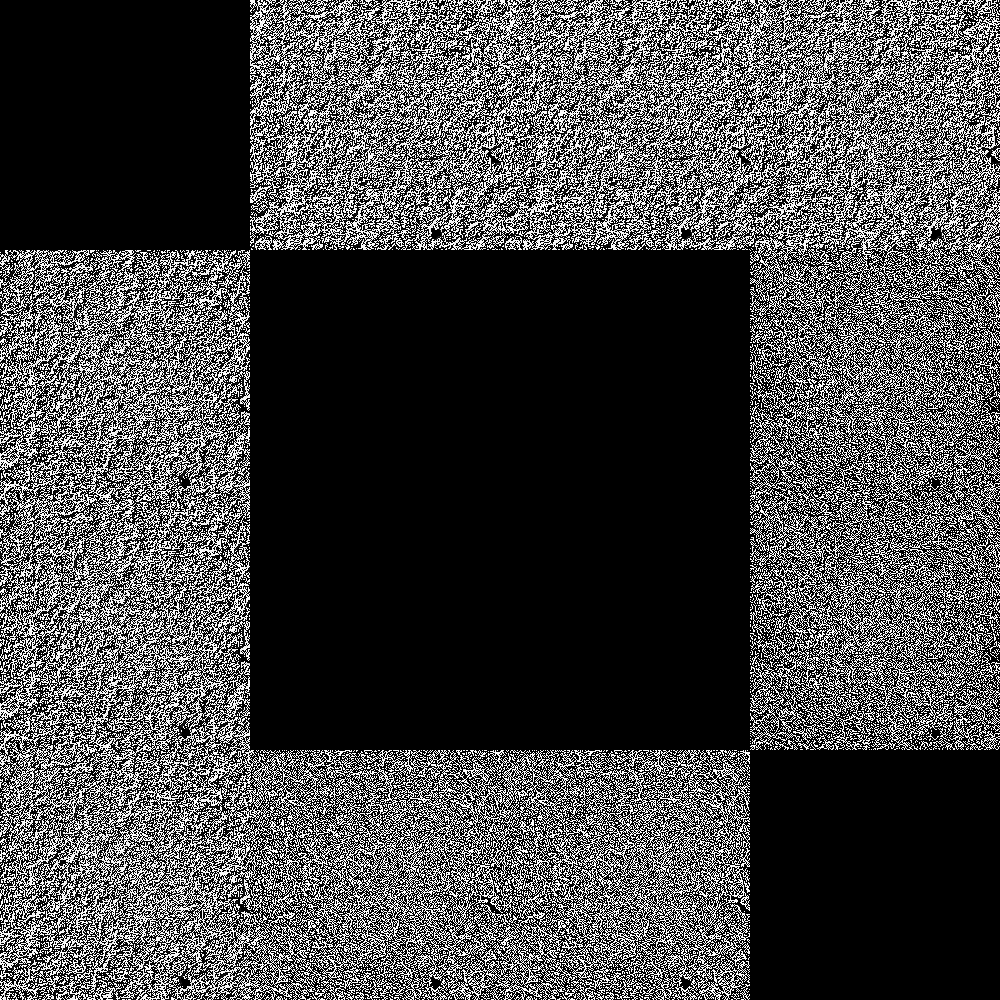

In [99]:
from itertools import product
import numpy as np

resized_images = images[1:]
diff_resize_images = []

for img1 in resized_images:
    for img2 in resized_images:
        img1 = np.array(img1)
        img2 = np.array(img2)
        diff = np.abs(img1 - img2)
        diff_resize_images.append(Image.fromarray(diff))

make_images_grid(diff_resize_images, 4, 4)

## Дополнительные данные
# TODO

In [11]:
image = cv2.imread('../../data/leman_sem_sand/1294/images/plug_44A_image_4.png')
image.shape

(12288, 16384, 3)

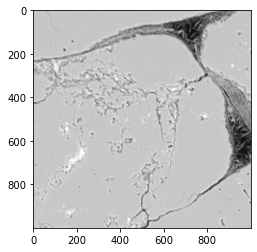

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image[:1000, :1000, :])

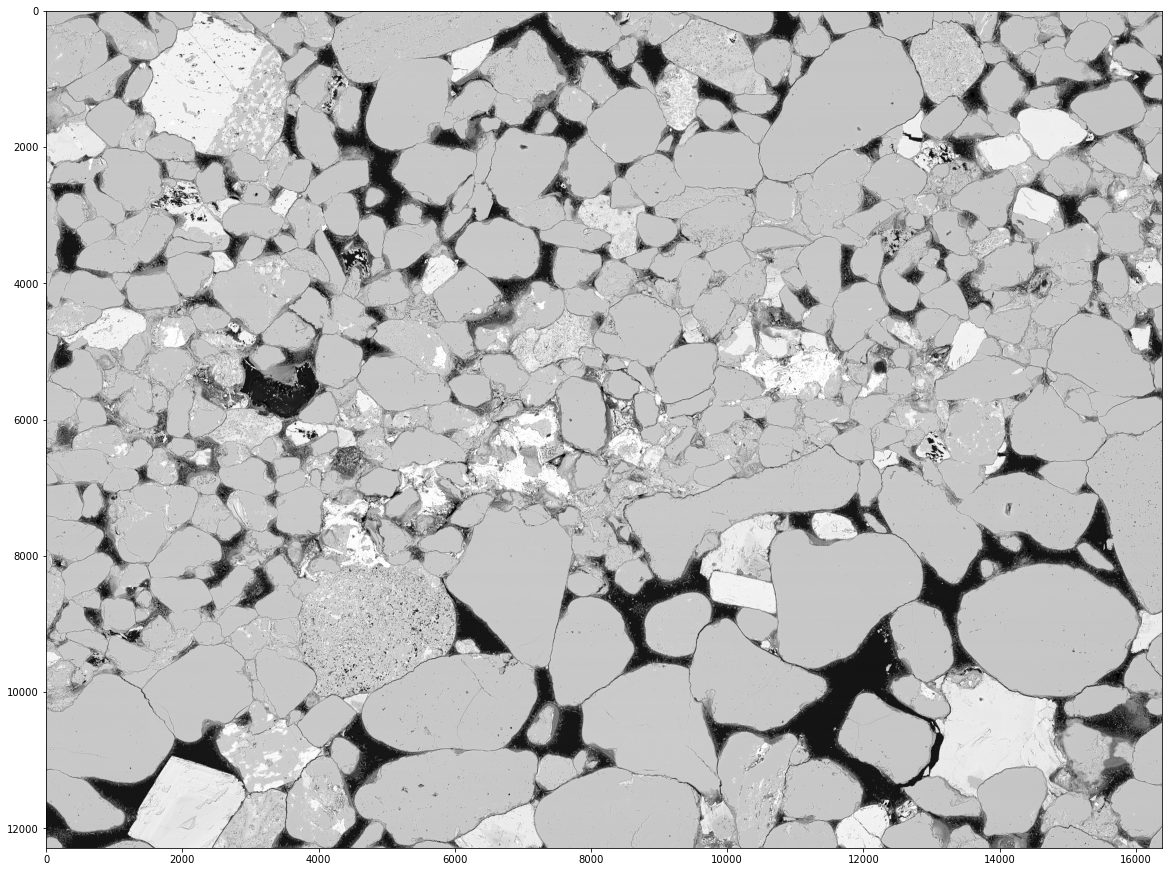

In [13]:
plt.figure(figsize=(20, 20))
plt.imshow(image)

## Дополнительные данные с масками сегментации
# TODO